In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

   Channel  Energy_keV  Counts
0        0    0.000000    1492
1        1    0.976562    1487
2        2    1.953125    1494
3        3    2.929688    1464
4        4    3.906250    1465


Text(0, 0.5, 'Counts')

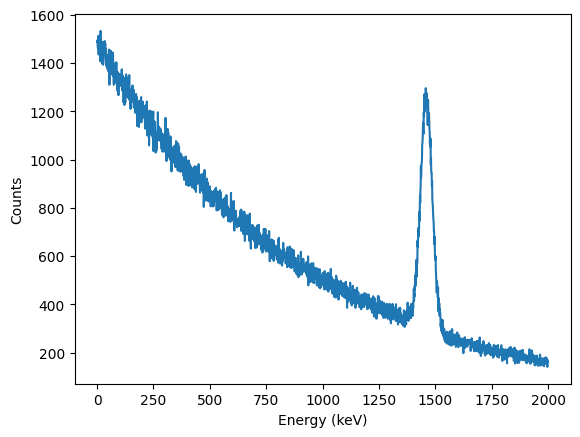

In [12]:
df = pd.read_csv(r'C:\Users\USER\Desktop\Research_Project\alpha-spectroscopy-fitting-Project-Athena\data\synthetic\K40_spectrum.csv')
print(df.head())
x = df['Energy_keV'].values
y = df['Counts'].values
plt.plot(x, y)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

In [13]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

def background(x, c0, c1, c2):
    # c0 + c1 * exp(-c2 * x)
    return c0 + c1 * np.exp(-c2 * x)

def model(x, A, mu, sigma, c0, c1, c2):
    return gaussian(x, A, mu, sigma) + background(x, c0, c1, c2)

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

def estimate_sigma_from_fwhm(x, y, peak_index=None, smooth_sigma=2, min_sep=1):
    """
    Estimate Gaussian sigma from the FWHM measured on (x,y).
    Returns (mu0, A0, sigma0, FWHM). If estimation fails, returns sensible fallbacks.
    
    x, y : 1D arrays (energy, counts)
    peak_index : index of peak in arrays (optional). If None uses global max.
    smooth_sigma : sigma for Gaussian smoothing to reduce noise before finding crossings.
    min_sep : minimum number of points separation between left and right crossing.
    """
    # Ensure numpy arrays and ascending x
    x = np.asarray(x)
    y = np.asarray(y)
    if x.size != y.size:
        raise ValueError("x and y must have same length")
    # Optional smoothing to reduce noisy local crossings
    if smooth_sigma is not None and smooth_sigma > 0:
        y_s = gaussian_filter1d(y, smooth_sigma)
    else:
        y_s = y.copy()
    # Peak location
    if peak_index is None:
        peak_index = np.argmax(y_s)
    mu0 = x[peak_index]
    A0 = y_s[peak_index] - np.median(y)   # amplitude above baseline guess
    half = (y_s[peak_index] + np.median(y)) / 2.0  # half-height between baseline and peak

    # Search left from peak for crossing y = half, and right for crossing
    # Use interpolation to find better crossing positions
    # Left side
    left_ix = np.where(x < mu0)[0]
    right_ix = np.where(x > mu0)[0]
    x_left_cross = None
    x_right_cross = None

    try:
        if left_ix.size > 1:
            xl = x[left_ix]
            yl = y_s[left_ix]
            # find last index where yl < half (moving left->right)
            # ensure we have a bracket around half
            mask = yl <= half
            if mask.any():
                # find bracket indices i0,i1 such that yl[i0] <= half <= yl[i1]
                # we want the crossing closest to the peak, i.e., last such before peak
                idx = np.where(mask)[0][-1]
                if idx < len(xl)-1:
                    f = interp1d(yl[idx:idx+2], xl[idx:idx+2])
                    x_left_cross = float(f(half))
        if right_ix.size > 1:
            xr = x[right_ix]
            yr = y_s[right_ix]
            mask = yr <= half
            if mask.any():
                idx = np.where(mask)[0][0]
                if idx > 0:
                    # bracket is (idx-1, idx)
                    f = interp1d(yr[idx-1:idx+1], xr[idx-1:idx+1])
                    x_right_cross = float(f(half))
    except Exception:
        x_left_cross = x_right_cross = None

    # If interpolation search failed, try a simpler crossing search scanning outward
    if x_left_cross is None:
        # scan from peak_index downwards to find crossing pair
        i = peak_index
        while i > 0 and y_s[i] > half:
            i -= 1
        if i >= 0 and i < peak_index:
            # linear interp between i and i+1
            x0, x1 = x[i], x[i+1]; y0, y1 = y_s[i], y_s[i+1]
            if (y1 - y0) != 0:
                x_left_cross = x0 + (half - y0) * (x1 - x0) / (y1 - y0)

    if x_right_cross is None:
        i = peak_index
        N = len(x)
        while i < N-1 and y_s[i] > half:
            i += 1
        if i > peak_index and i < N:
            x0, x1 = x[i-1], x[i]; y0, y1 = y_s[i-1], y_s[i]
            if (y1 - y0) != 0:
                x_right_cross = x0 + (half - y0) * (x1 - x0) / (y1 - y0)

    # Compute FWHM and sigma
    if (x_left_cross is not None) and (x_right_cross is not None) and (x_right_cross - x_left_cross > min_sep * (x[1]-x[0])):
        fwhm = x_right_cross - x_left_cross
        sigma0 = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # FWHM / 2.35482...
    else:
        # fallback: estimate width from second moment around peak or default value
        # compute a crude RMS width using points within e.g. 0.5*peak height
        mask = (x >= mu0 - 10*(x[1]-x[0])) & (x <= mu0 + 10*(x[1]-x[0]))
        if mask.sum() > 3:
            ypeak = y_s[mask]
            xpeak = x[mask]
            # second moment as fallback
            mean = np.sum(xpeak * ypeak) / np.sum(ypeak)
            var = np.sum(ypeak * (xpeak - mean)**2) / np.sum(ypeak)
            sigma0 = np.sqrt(var) if var > 0 else max(1.0, (x[1]-x[0]))
            fwhm = sigma0 * 2.35482
        else:
            sigma0 = max(1.0, (x[1]-x[0]))  # single-channel fallback
            fwhm = sigma0 * 2.35482

    return mu0, A0, sigma0, fwhm


In [15]:
mu0, A0, sigma0, fwhm = estimate_sigma_from_fwhm(x, y, smooth_sigma=3)
print("Initial guess: mu0=%.2f, A0=%.1f, sigma0=%.3f (FWHM=%.3f)" % (mu0, A0, sigma0, fwhm))




Initial guess: mu0=0.00, A0=931.0, sigma0=3.088 (FWHM=7.273)


In [6]:
c0_0 = np.median(y[(x<100) | (x>1200)])  # baseline offset guess from edges
c1_0 = (np.median(y[x<200]) - c0_0)  # amplitude of exponential part
c2_0 = 0.001  

In [7]:
p0 = [A0, mu0, sigma0, c0_0, c1_0, c2_0]  # for the gaussian+exp model earlier

In [8]:
# use bounds to keep parameters physical
lower = [0, mu0-20, 0.1, 0, -np.inf, 0]
upper = [np.inf, mu0+20, np.inf, np.inf, np.inf, np.inf]

# Weight by sqrt(y) to approximate Poisson errors (avoid zeros)
sigma_weights = np.sqrt(np.clip(y, 1, np.inf))

popt, pcov = curve_fit(model, x, y, p0=p0, bounds=(lower, upper), sigma=sigma_weights, absolute_sigma=True)

# produce fitted curve and residuals
y_fit = model(x, *popt)
residuals = y - y_fit

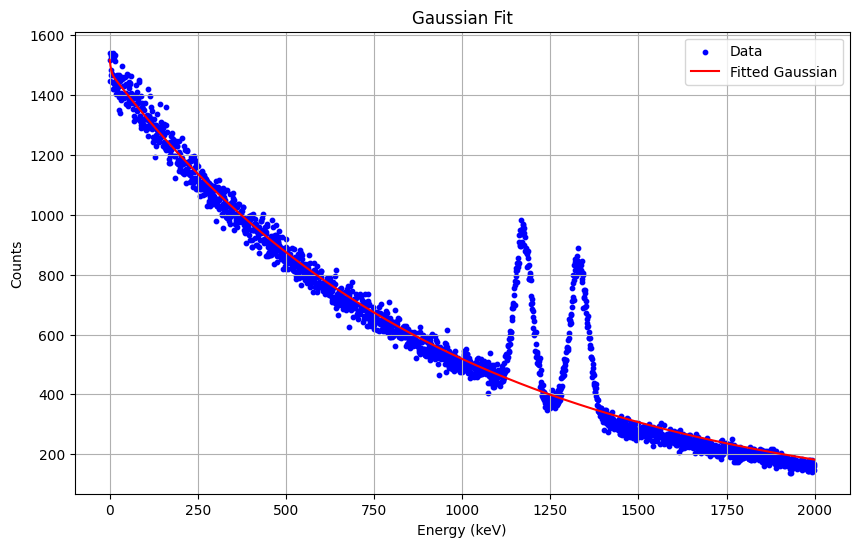

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(x,y,label="Data", color="blue", s=10)
plt.plot(x,y_fit, label="Fitted Gaussian", color="red", linewidth=1.5)
plt.title("Gaussian Fit")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)

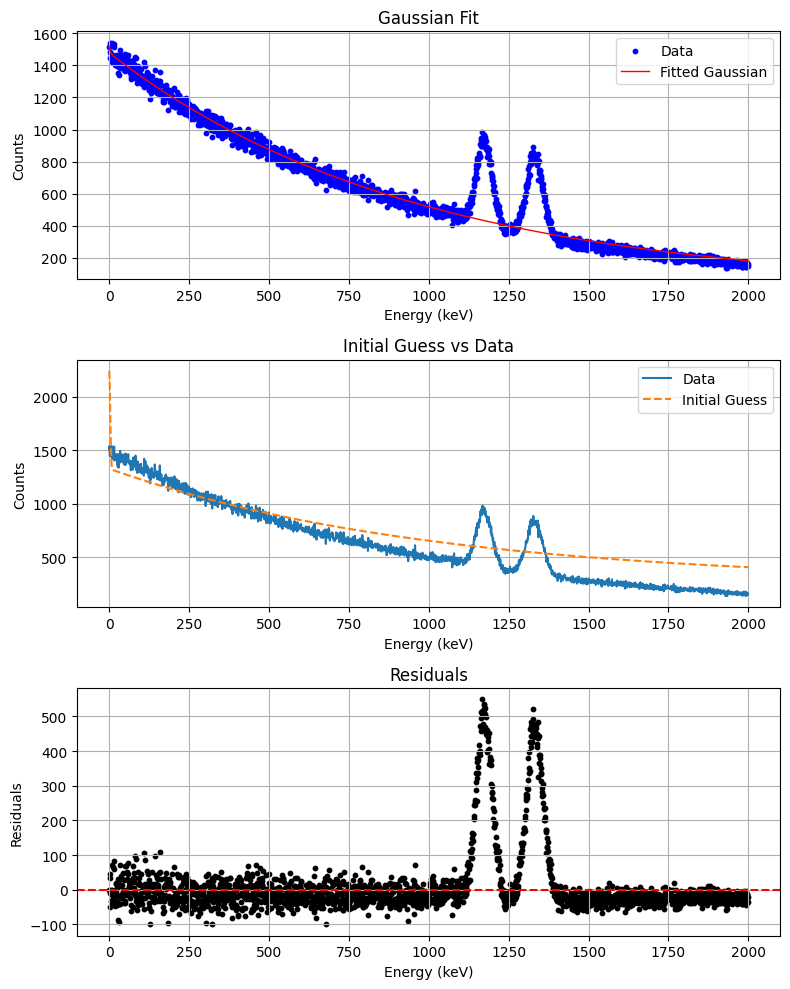

In [10]:
# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

# 1. Fit vs Data
axes[0].scatter(x, y, label="Data", color="blue", s=10)
axes[0].plot(x, y_fit, label="Fitted Gaussian", color="red", linewidth=1)
axes[0].set_title("Gaussian Fit")
axes[0].set_xlabel("Energy (keV)")
axes[0].set_ylabel("Counts")
axes[0].legend()
axes[0].grid(True)

# 2. Initial Guess vs Data
y_init = model(x, *p0)
axes[1].plot(x, y, label="Data")
axes[1].plot(x, y_init, label="Initial Guess", linestyle='--')
axes[1].set_title("Initial Guess vs Data")
axes[1].set_xlabel("Energy (keV)")
axes[1].set_ylabel("Counts")
axes[1].legend()
axes[1].grid(True)

# 3. Residuals
axes[2].scatter(x, residuals, s=10, color="black")
axes[2].axhline(0, color="red", linestyle="--")
axes[2].set_title("Residuals")
axes[2].set_xlabel("Energy (keV)")
axes[2].set_ylabel("Residuals")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [11]:
perr = np.sqrt(np.diag(pcov))  # 1σ uncertainties

param_names = ["A", "mu", "sigma", "c0", "c1", "c2"]

print("\nFit Results (with 1σ uncertainties):")
for name, val, err in zip(param_names, popt, perr):
    print(f"{name:5s} = {val:.3f} ± {err:.3f}")

# Also compute reduced Chi-square
residuals = y - y_fit
dof = len(y) - len(popt)  # degrees of freedom
chi2 = np.sum((residuals / np.sqrt(np.clip(y, 1, np.inf)))**2)
chi2_red = chi2 / dof
print(f"Reduced Chi² = {chi2_red:.3f}")


Fit Results (with 1σ uncertainties):
A     = 494.094 ± 34500.697
mu    = -19.999 ± 493.106
sigma = 8.938 ± 96.846
c0    = 0.000 ± 3.062
c1    = 1477.640 ± 2.509
c2    = 0.001 ± 0.000
Reduced Chi² = 14.740


In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def estimate_sigma_from_fwhm(x, y, peak_index=None, smooth_sigma=2, min_sep=1, min_energy_threshold=200, prominence_factor=0.1, height_factor=0.05):
    """
    Estimate Gaussian sigma from the FWHM measured on (x,y).
    Returns (mu0, A0, sigma0, FWHM). If estimation fails, returns sensible fallbacks.
    
    Parameters:
    - x, y: 1D arrays (energy, counts)
    - peak_index: Index of peak in arrays (optional). If None, uses find_peaks to detect.
    - smooth_sigma: Sigma for Gaussian smoothing to reduce noise before finding crossings.
    - min_sep: Minimum number of points separation between left and right crossing.
    - min_energy_threshold: Minimum energy (keV) to ignore low-energy noise.
    - prominence_factor: Fraction of max counts for peak prominence.
    - height_factor: Fraction of max counts for minimum peak height.
    """
    # Ensure numpy arrays and ascending x
    x = np.asarray(x)
    y = np.asarray(y)
    if x.size != y.size:
        raise ValueError("x and y must have same length")
    
    # Optional smoothing to reduce noisy local crossings
    if smooth_sigma is not None and smooth_sigma > 0:
        y_s = gaussian_filter1d(y, smooth_sigma)
    else:
        y_s = y.copy()
    
    # Peak location
    if peak_index is None:
        # Mask low-energy region to avoid noise
        mask = x > min_energy_threshold
        if not np.any(mask):
            raise ValueError(f"No data above {min_energy_threshold} keV. Adjust threshold.")
        
        # Find peaks in smoothed counts
        prominence = prominence_factor * np.max(y_s[mask])
        height = height_factor * np.max(y_s[mask])
        peaks, properties = find_peaks(y_s, prominence=prominence, height=height)
        
        if len(peaks) == 0:
            raise ValueError("No peaks found. Adjust prominence_factor or height_factor.")
        
        # Select the tallest peak
        sorted_indices = np.argsort(properties['peak_heights'])[::-1]
        peak_index = peaks[sorted_indices[0]]
    
    mu0 = x[peak_index]
    A0 = y_s[peak_index] - np.median(y)  # Amplitude above baseline guess
    half = (y_s[peak_index] + np.median(y)) / 2.0  # Half-height between baseline and peak

    # Search left from peak for crossing y = half, and right for crossing
    # Use interpolation to find better crossing positions
    x_left_cross = None
    x_right_cross = None

    try:
        left_ix = np.where(x < mu0)[0]
        right_ix = np.where(x > mu0)[0]
        if left_ix.size > 1:
            xl = x[left_ix]
            yl = y_s[left_ix]
            mask = yl <= half
            if mask.any():
                idx = np.where(mask)[0][-1]
                if idx < len(xl)-1:
                    f = interp1d(yl[idx:idx+2], xl[idx:idx+2])
                    x_left_cross = float(f(half))
        if right_ix.size > 1:
            xr = x[right_ix]
            yr = y_s[right_ix]
            mask = yr <= half
            if mask.any():
                idx = np.where(mask)[0][0]
                if idx > 0:
                    f = interp1d(yr[idx-1:idx+1], xr[idx-1:idx+1])
                    x_right_cross = float(f(half))
    except Exception:
        x_left_cross = x_right_cross = None

    # If interpolation search failed, try a simpler crossing search scanning outward
    if x_left_cross is None:
        i = peak_index
        while i > 0 and y_s[i] > half:
            i -= 1
        if i >= 0 and i < peak_index:
            x0, x1 = x[i], x[i+1]
            y0, y1 = y_s[i], y_s[i+1]
            if (y1 - y0) != 0:
                x_left_cross = x0 + (half - y0) * (x1 - x0) / (y1 - y0)

    if x_right_cross is None:
        i = peak_index
        N = len(x)
        while i < N-1 and y_s[i] > half:
            i += 1
        if i > peak_index and i < N:
            x0, x1 = x[i-1], x[i]
            y0, y1 = y_s[i-1], y_s[i]
            if (y1 - y0) != 0:
                x_right_cross = x0 + (half - y0) * (x1 - x0) / (y1 - y0)

    # Compute FWHM and sigma
    if (x_left_cross is not None) and (x_right_cross is not None) and (x_right_cross - x_left_cross > min_sep * (x[1]-x[0])):
        fwhm = x_right_cross - x_left_cross
        sigma0 = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # FWHM / 2.35482...
    else:
        mask = (x >= mu0 - 10*(x[1]-x[0])) & (x <= mu0 + 10*(x[1]-x[0]))
        if mask.sum() > 3:
            ypeak = y_s[mask]
            xpeak = x[mask]
            mean = np.sum(xpeak * ypeak) / np.sum(ypeak)
            var = np.sum(ypeak * (xpeak - mean)**2) / np.sum(ypeak)
            sigma0 = np.sqrt(var) if var > 0 else max(1.0, (x[1]-x[0]))
            fwhm = sigma0 * 2.35482
        else:
            sigma0 = max(1.0, (x[1]-x[0]))  # Single-channel fallback
            fwhm = sigma0 * 2.35482

    return mu0, A0, sigma0, fwhm